# Методы снижения размерностей

In [15]:
#Установите библиотеки
!pip install MulticoreTSNE bokeh scikit-learn gensim

You should consider upgrading via the 'pip install --upgrade pip' command.


## Различные методы снижения размерностей

[sklearn docs](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, neighbors)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


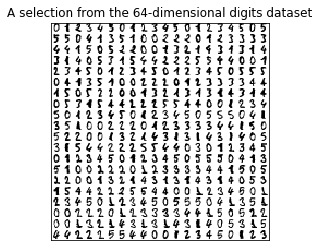

In [2]:
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');


Computing PCA projection


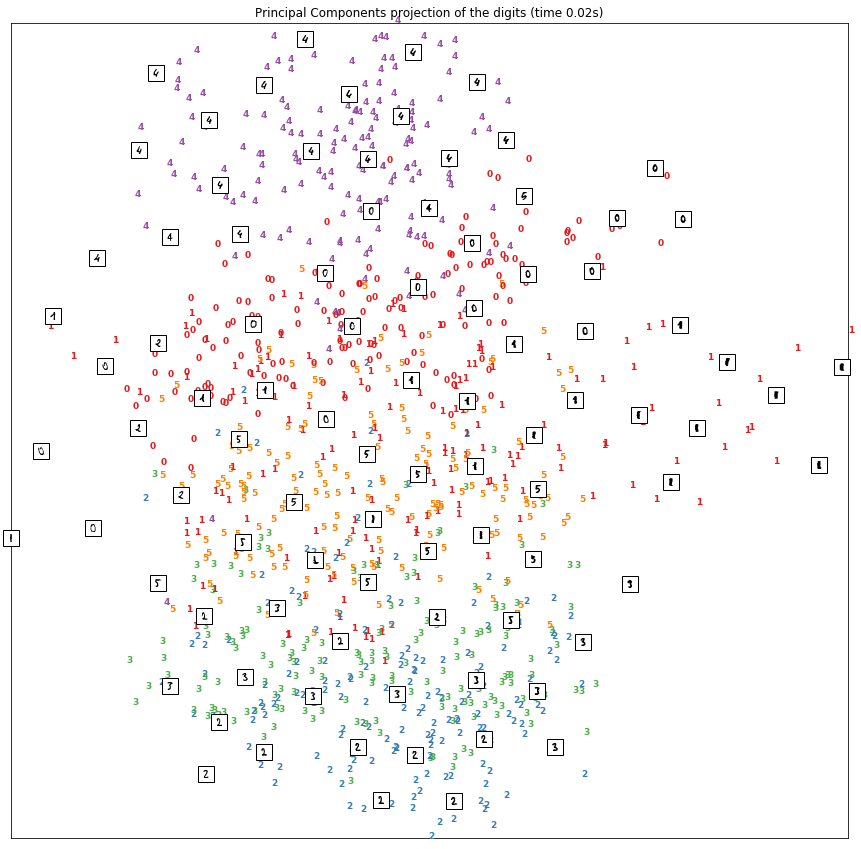

In [3]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))


Computing Isomap projection


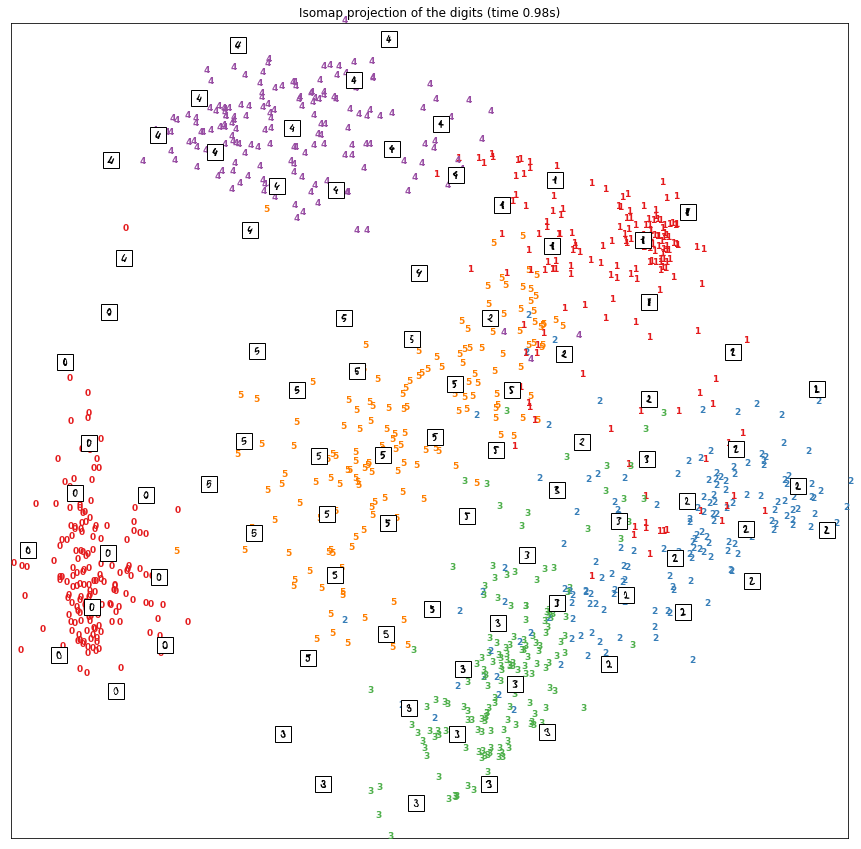

In [4]:
print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))


Computing t-SNE embedding


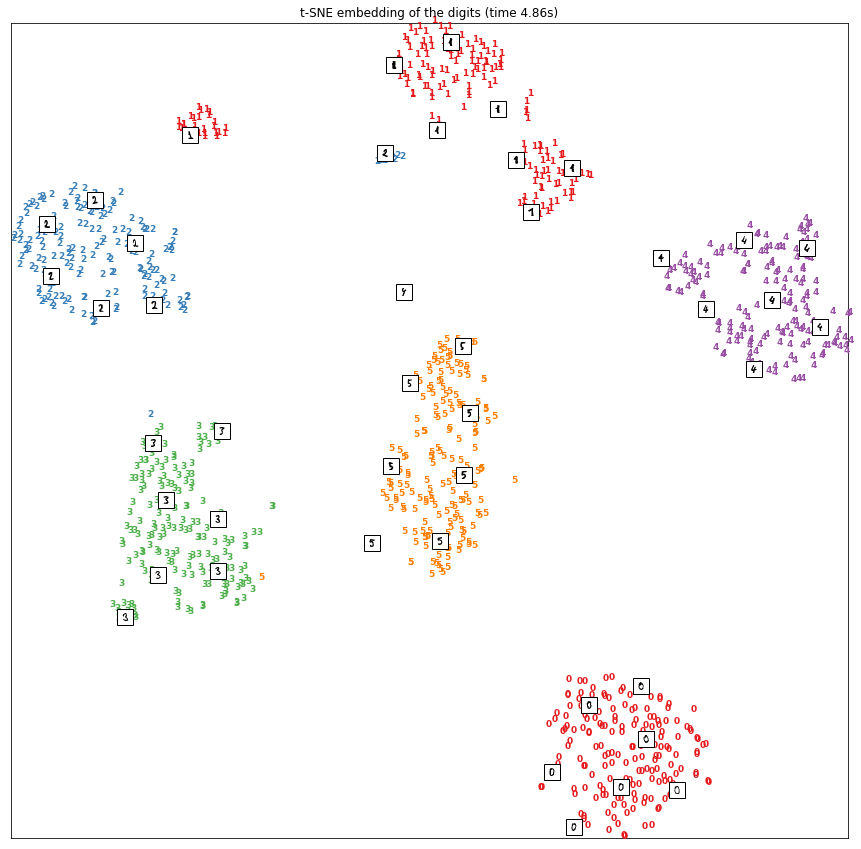

In [5]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))


## TSNE для эмбеддингов слов

Допустим у нас есть word2vec модель, обученная на российских новостях без предобработки. Давайте посмотри на то, какие эмбеддинги получились.

Для этого мы будем использовать TSNE.

Данные [здесь](https://cloud.mail.ru/public/26Da/AuAhoLbqZ) - вам нужен cc.ru.300.vec.zip

In [6]:
import argparse
import numpy as np
import gensim

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LabelSet, HoverTool
from numpy.linalg import norm
from MulticoreTSNE import MulticoreTSNE as TSNE
from gensim.models import KeyedVectors

In [ ]:
!unzip cc.ru.300.vec.zip

In [7]:
ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")
ru_emb.vectors.shape

/Users/d.parpulov/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(600000, 300)

In [8]:
top_k = 1000
words = ru_emb.index2word[:top_k]
embeddings = ru_emb.vectors[:top_k]
tsne = TSNE(n_jobs=4, perplexity=20)
Y = tsne.fit_transform(embeddings)
source = ColumnDataSource(data=dict(x=Y[:,0], y=Y[:,1], words=words))
hover = HoverTool(tooltips=[("word", "@words")])

TOOLS = ['pan', 'wheel_zoom', 'reset', hover]
p = figure(title='t-SNE embedding of top ' + str(len(Y)) + ' words',
        plot_width=1200, plot_height=720, tools=TOOLS)
p.scatter(x='x', y='y', size=8, source=source)
labels = LabelSet(x='x', y='y', text='words', level='glyph',
        x_offset=5, y_offset=5, source=source, render_mode='canvas')
p.add_layout(labels)
show(p)

## SVD
посмотрим, как влияет количество компонент для разложения на точность восстановления исходной выборки

In [68]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from time import time
import matplotlib.pyplot as plt

import numpy as np

In [69]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset")
vectorizer = TfidfVectorizer()

X_vect = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_vect.shape)
print()

3387 documents
4 categories

Extracting features from the training dataset
done in 126.067475s
n_samples: 3387, n_features: 43562



In [60]:
ex_var = []
n_comp = [10, 50, 100, 300, 500, 1000, 2000, 3000]

for n in n_comp:
    t0 = time()
    svd = TruncatedSVD(n_components=n)
    X = svd.fit_transform(X_vect)    
    ex_var.append(svd.explained_variance_ratio_.sum())
    print(f"Dimensionality reduction with %s components done in %.3fs" % (n , (time() - t0)) ) 

3387 documents
4 categories

Extracting features from the training dataset
done in 17.115885s
n_samples: 3387, n_features: 43562

Dimensionality reduction with 10 components done in 0.193s
Dimensionality reduction with 50 components done in 0.871s
Dimensionality reduction with 100 components done in 1.914s
Dimensionality reduction with 300 components done in 5.616s
Dimensionality reduction with 500 components done in 11.500s
Dimensionality reduction with 1000 components done in 27.552s
Dimensionality reduction with 2000 components done in 90.735s
Dimensionality reduction with 3000 components done in 130.286s


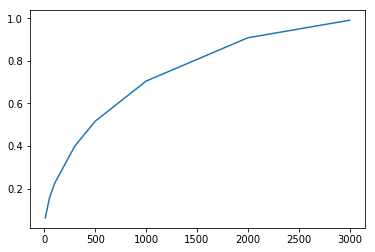

In [61]:
plt.plot(n_comp, ex_var)

In [63]:
ex_var

[0.06189716380684329,
 0.1533710507224969,
 0.22285109611239856,
 0.3992658172597728,
 0.5158692076229872,
 0.7046331069335131,
 0.9081814356990628,
 0.9905001340311383]

Видим, что первые 3к компонент соджержат 99% дисперсии исходной выборки. 
Таким образом, мы можем на порядок сократить количество признаков (вместо исходных 43к), и использовать новые признаки для построения классификатора